In [5]:
import ipywidgets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.spatial import distance
import seaborn as sns
from sklearn.decomposition import FastICA, PCA 

sns.set(style='white', context='notebook')

%matplotlib inline

/Users/olga/anaconda3/envs/single-cell-bioinformatics-v3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Hierarchical clustering

### Distance metrics: Euclidean vs Manhattan
One important point of how you cluster data is which distance metric you use.

- Euclidean distance is what you learned in algebra class: $d(x, y) = \sqrt{x^2 + y^2}$, but all the way to $N$ dimensional vectors ($\vec{x}, \vec{y}$ represent $N$-dimensional vectors): $d(\vec{x}, \vec{y}) = \sqrt{\sum_i^N \left(x_i -y_i\right)^2}$
- Manhattan distance (also called "taxicab geometry") is similar but no squares or square roots: $d(\vec{x}, \vec{y}) = \sum_i^N |x_i - y_i|$

![](https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Manhattan_distance.svg/283px-Manhattan_distance.svg.png)

### Correlation metrics

#### Spearman correlation
[Spearman correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)`
answers the simple question, every time $x$ increases, does $y$ increase also? If yes, then spearman correlation = 1.

Mathematically speaking, Spearman tells you whether $x$ and $y$ increase monotonically together

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4e/Spearman_fig1.svg/360px-Spearman_fig1.svg.png)


#### Pearson correlation
[Pearson Correlation](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient) answers the question, every time my $x$ decreases by some amount $a$, does $y$ decrease by an amount proportional to that, say $10a$ or $0.5a$, and is this amount constant?

$\rho_{x,y} = \frac{\mathrm{cov}(\vec{x}, \vec{y})}{\sigma_x, \sigma_y}$

Mathematically speaking, pearson tells you whether $x$ and $y$ are *linear* to each other.

![](https://upload.wikimedia.org/wikipedia/commons/3/34/Correlation_coefficient.png)

#### Spearman vs Pearson

Spearman's correlation is related to Pearson because Spearman 

Spearman correlation = Pearson correlation on the ranks of the data

### Anscombe's quartet 

Anscombe's quartet is a group of four datasets that have nearly identical statistical properties that we'll use for exploring distance and correlation metrics.

/Users/olga/anaconda3/envs/single-cell-bioinformatics-v3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


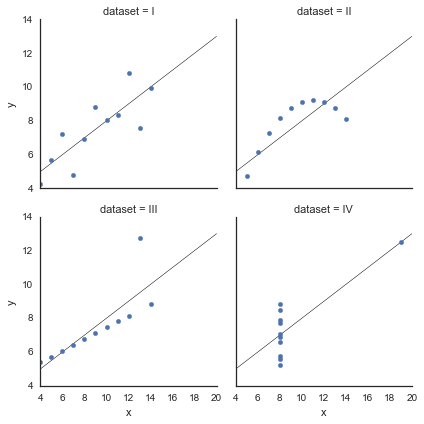

In [6]:
anscombe = sns.load_dataset('anscombe')

x = np.arange(4, 21)
y = 3 + 0.5*x

g = sns.FacetGrid(anscombe, col='dataset', col_wrap=2)
g.map(plt.scatter, 'x', 'y')
for ax in g.axes.flat:
    ax.plot(x, y, '-', color='k', zorder=-1, linewidth=0.5)
    ax.set(xlim=(4, 20), ylim=(4, 14))

dataset         I        II  III        IV
x        9.000000  9.000000  9.0  9.000000
y        7.500909  7.500909  7.5  7.500909


/Users/olga/anaconda3/envs/single-cell-bioinformatics-v3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


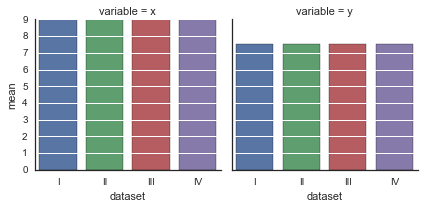

In [7]:
grouped = anscombe.groupby('dataset')

statistical = 'mean', 'var', 'std'

def explore_anscombe(summary):
    col = None
    
    if summary in statistical:
        summarized = getattr(grouped, summary)()
        tidy = summarized.unstack().reset_index()
        tidy = tidy.rename(columns={'level_0': 'variable', 0: summary})
        col = 'variable'
    else:
        if summary.endswith('correlation'):
            method = summary.split()[0].lower()
            summarized = grouped.apply(lambda df: df['x'].corr(df['y'], method=method))
        elif summary.endswith('distance'):
            metric = getattr(distance, summary.split()[0].lower())
            summarized = grouped.apply(lambda df: metric(df['x'], df['y'])) 
        tidy = summarized.reset_index()
        tidy = tidy.rename(columns={'index': 'variable', 0: summary})
    print(summarized.T)

    g = sns.factorplot(data=tidy, col=col, x='dataset', 
                       y=summary, kind='bar', size=3, zorder=-1)
    for ax in g.axes.flat:
        # add a white grid on top
        ax.grid(axis='y', color='white', zorder=2)
    
ipywidgets.interact(explore_anscombe,
                    summary=['mean', 'var', 'std', 
                             'Pearson correlation', 
                             'Spearman correlation',
                             'Euclidean distance', 
                             'Cityblock distance']);

### Quiz 2.1.1

Open up this [quiz](https://docs.google.com/forms/d/1DmGgjhvI_IWagsyANoMmv9dgRRZcw8JPJasY-AqKWeU/viewform) to work on while you play with the widgets.

### Linkage methods: Ward, average, single, complete

![Linkage methods](figures/linkage_methods.jpg)

* Single: Compares shortest distance between clusters
* Complete: Compares largest distance between clusters
* Average: Compares average distance between clusters
* Ward: Within cluster, compares average distance to centroid
* Centroid: Compares centroid points of clusters

source: http://www.slideshare.net/neerajkaushik/cluster-analysis


We'll use a couple different datasets for studying linkage methods

#### "Mouse data"

WE'll use the same "mouse data" we used yesterday for looking at bach effects.

/Users/olga/anaconda3/envs/single-cell-bioinformatics-v3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


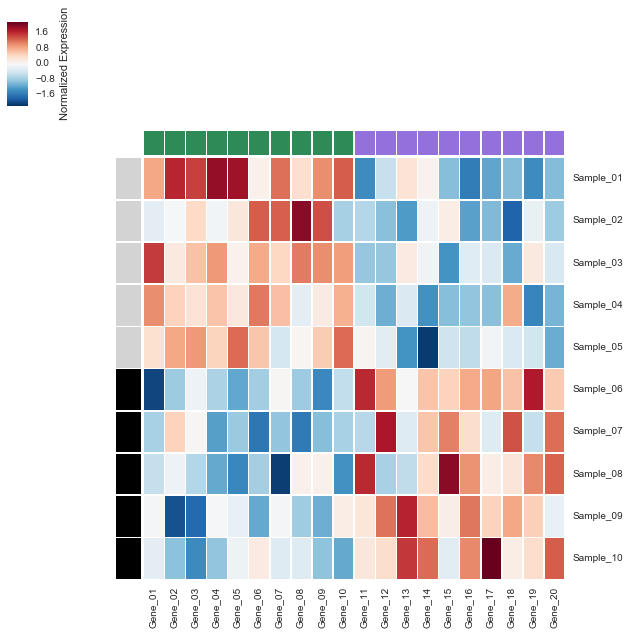

In [8]:
np.random.seed(2016)

n_samples = 10
n_genes = 20

half_genes = int(n_genes/2)
half_samples = int(n_samples/2)
size = n_samples * n_genes

genes = ['Gene_{}'.format(str(i+1).zfill(2)) for i in range(n_genes)]
samples = ['Sample_{}'.format(str(i+1).zfill(2)) for i in range(n_samples)]

mouse_data = pd.DataFrame(np.random.randn(size).reshape(n_samples, n_genes), index=samples, columns=genes)

# Add biological variance
mouse_data.iloc[:half_samples, :half_genes] += 1
mouse_data.iloc[:half_samples, half_genes:] += -1
mouse_data.iloc[half_samples:, half_genes:] += 1
mouse_data.iloc[half_samples:, :half_genes] += -1

# Z_score within genes
mouse_data = (mouse_data - mouse_data.mean())/mouse_data.std()

# Biological samples
mouse_groups = pd.Series(dict(zip(mouse_data.index, (['Mouse_01'] * int(n_samples/2)) + (['Mouse_02'] * int(n_samples/2)))), 
                         name="Mouse")
mouse_to_color = dict(zip(['Mouse_01', 'Mouse_02'], ['lightgrey', 'black']))
mouse_colors = [mouse_to_color[mouse_groups[x]] for x in samples]

# Gene colors
gene_colors = (['SeaGreen'] * half_genes) + (['MediumPurple'] * half_genes)
mouse_row_colors = mouse_colors
mouse_col_colors = gene_colors 

g = sns.clustermap(mouse_data, row_colors=mouse_row_colors, col_cluster=False, row_cluster=False, 
                   linewidth=0.5, col_colors=mouse_col_colors,
                   cbar_kws=dict(label='Normalized Expression'))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0);

#### Pseudotime data

We'll use an artificial "psuedotime" ordered dataset, where some genes turn on or off along the data, nonlinearly, plus there's an intermediate population:

/Users/olga/anaconda3/envs/single-cell-bioinformatics-v3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


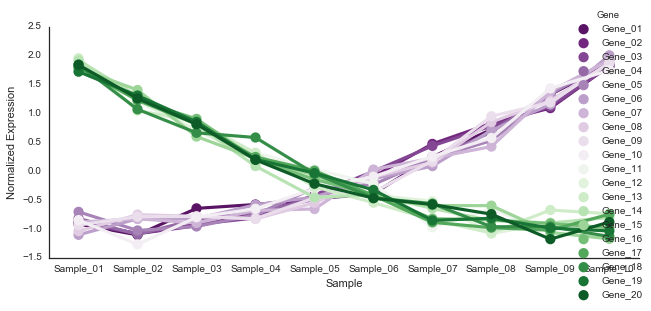

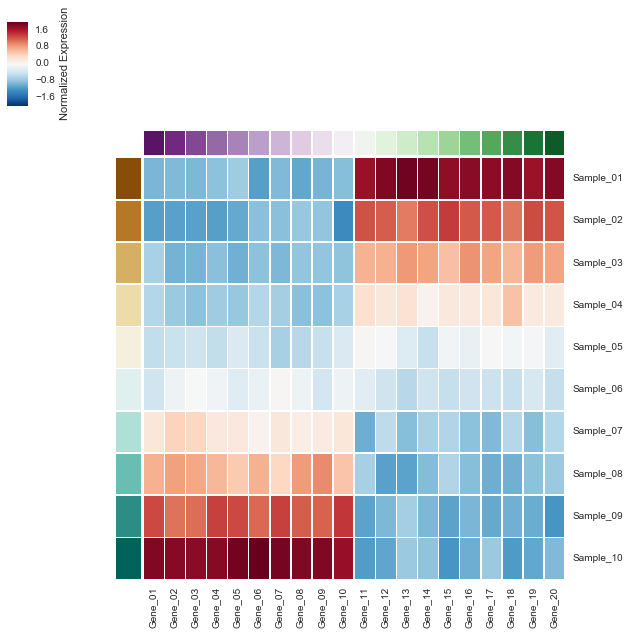

In [9]:
np.random.seed(2016)

n_samples = 10
n_genes = 20

half_genes = int(n_genes/2)
half_samples = int(n_samples/2)
size = n_samples * n_genes

genes = ['Gene_{}'.format(str(i+1).zfill(2)) for i in range(n_genes)]
samples = ['Sample_{}'.format(str(i+1).zfill(2)) for i in range(n_samples)]

pseudotime_data = pd.DataFrame(np.random.randn(size).reshape(n_samples, n_genes), index=samples, columns=genes)

# Add "psueodotime"
pseudotime_data.iloc[:, :half_genes] = pseudotime_data.iloc[:, :half_genes].add(np.square(np.arange(n_samples)/2), axis=0)
pseudotime_data.iloc[:, half_genes:] = pseudotime_data.iloc[:, half_genes:].add(np.square(np.arange(n_samples)[::-1]/2), axis=0)


# Normalize genes using z-scores
pseudotime_data = (pseudotime_data - pseudotime_data.mean())/pseudotime_data.std()

pseudotime_row_colors = sns.color_palette('BrBG', n_colors=n_samples)
pseudotime_col_colors = sns.color_palette("PRGn", n_colors=n_genes)
tidy = pseudotime_data.unstack().reset_index()
tidy = tidy.rename(columns={'level_0': 'Gene', 'level_1': "Sample", 0:'Normalized Expression'})
tidy.head()

g = sns.factorplot(data=tidy, hue='Gene', palette=pseudotime_col_colors, x='Sample', 
                   y='Normalized Expression', aspect=2)
# g.map(plt.plot, x='Sample', y='Normalized Expression')


g = sns.clustermap(pseudotime_data, row_colors=pseudotime_row_colors, col_cluster=False, row_cluster=False, 
                   linewidth=0.5, col_colors=pseudotime_col_colors,
                   cbar_kws=dict(label='Normalized Expression'))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0);

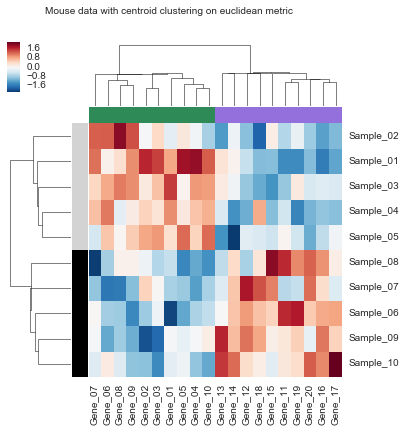

In [10]:
def explore_clustering(dataset, metric, method, row_cluster, col_cluster, correlate):
    if dataset == "Mouse":
        data = mouse_data
        col_colors = mouse_col_colors
        row_colors = mouse_row_colors
    elif dataset == 'Pseudotime':
        data = pseudotime_data
        col_colors = pseudotime_col_colors
        row_colors = pseudotime_row_colors        
    if correlate != "No":
        data = data.T.corr(method=correlate.lower())
        col_colors = row_colors
        
#     yticks = g.ax_col_dendrogram.get_ylim()
#     xticks = g.ax_row_dendrogram.get_xlim()
#     g.ax_col_dendrogram.set(yticks=yticks, 
#                             yticklabels=['{:.1f}'.format(tick) for tick in yticks])
#     g.ax_row_dendrogram.set(xticks=xticks, 
#                             xticklabels=['{:.1f}'.format(tick) for tick in xticks])

    g = sns.clustermap(data, figsize=(6, 6), #annot=True, fmt='d', 
                       row_colors=row_colors, col_colors=col_colors, 
                       metric=metric, method=method,
                      col_cluster=col_cluster, row_cluster=row_cluster)
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation='horizontal');
    if col_cluster or row_cluster:
        title_suffix = ' with {} clustering on {} metric'.format(method, metric)
    else:
        title_suffix = ''
    g.fig.suptitle('{} data'.format(dataset) + title_suffix)
    
ipywidgets.interact(explore_clustering,
                    dataset=ipywidgets.Dropdown(options=['Mouse', 'Pseudotime'], value='Mouse', 
                                                description='Dataset'),
                    metric=ipywidgets.Dropdown(options=['euclidean', 'cityblock', ], value='euclidean', 
                                               description='Distance metric'),
                    method=ipywidgets.Dropdown(options=['complete', 'single', 'average', 'ward', 'centroid'], value='average', 
                                               description='Linkage method'),
                    row_cluster=ipywidgets.Checkbox(value=True, description='Cluster rows?'),
                    col_cluster=ipywidgets.Checkbox(value=True, description='Cluster columns?'),
                    correlate=ipywidgets.Dropdown(
        options=['No', 'Pearson', 'Spearman'], value='No', description='Cluster on correlations?'));

Open up this [quiz](https://docs.google.com/forms/d/1bByfKEkLdxzKeNd_NyIrjSZGCCq2GK0cTCW4Fne1GPQ/viewform) to work on while you play with the widgets.

For these questions, don't cluster on sample correlations. The option is there for you if you want to see the difference.